In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
a0 = -0.3
a1 = 0.5

def noise(size, variance):
    return np.random.normal(scale=np.sqrt(variance), size=size)

def f(X, noise_variance):
    return a0 + a1 * X + noise(X.shape, noise_variance)

For a bayesian treatment of linear regression. We first assume that the target variable, $t$ is given by a deterministic function:

$y(\textbf{x}, \textbf{w}) + \epsilon$

Where $\epsilon$ is a zero mean Gaussian variable with inverse variance $\beta$. Thus we can write:

$p(t\vert \textbf{x}, \textbf{w}, \beta) = \mathcal{N}(t \vert y(\textbf{x}, \textbf{w}), \beta^{-1})$

For our prior, if we use a zero-mean isotropic Gaussian governed by a single precision parameter $\alpha$ so that: 

$p(\textbf{w}\vert\alpha) = \mathcal{N}({\textbf{w}\vert \textbf{0}}, \alpha^{-1}\textbf{I})$

then, the corresponding posterior has a closed form solution given by:

$p(\textbf{w}\vert\textbf{t}) = \mathcal{N}(\textbf{w}\vert\textbf{m}_{N}, \textbf{S}_{N})$

where:

$\textbf{m}_{N} = \beta \textbf{S}_{N} \Phi^{T}\textbf{t}\\
\textbf{S}_N^{-1} = \alpha \textbf{I} + \beta \Phi^{T}\Phi$

In practice, we are not usaully interested in the single values of $w$ but rather in making predictions of $t$ for new values of $\textbf{x}$. This is done by using the predictive distribution, defined as follows: 

$p(t\vert\textbf{t},\alpha,\beta) = \int p(t\vert\textbf{w},\beta)p(\textbf{w}\vert\textbf{t},\alpha,\beta)$

The conditional distribution $p(t\vert\textbf{w}\beta)$ is defined in the model above. $p(\textbf{w}\vert\textbf{t},\alpha,\beta)$ represents our posterior distribution which is given by the closed form solution above. The predictive distribution is the convolution of two Gaussian distributions meaning that the predictive distribution is also Gaussian and is defined as follows: 

$p(t\vert\textbf{x},\textbf{t},\alpha,\beta) = \mathcal{N}(t\vert\textbf{m}_{N}^{T}\phi(\textbf{x}), \sigma_{N}^{2}(\textbf{x}))$

where the variance $\sigma_{N}^{2}$ is given by:

$\sigma_{N}^{2} = \dfrac{1}{\beta} + \phi(\textbf{x})^{T}\textbf{S}_{N}\phi{\textbf{(x)}}$

In [377]:
# basis functions
def identity_basis_function(x):
    return x

def attach_ones(X):
    nrows = X.shape[0]
    return np.concatenate([np.ones((nrows,1)), X], axis=1)

def posterior(alpha, beta, phi, t):
    '''mean and covariance matrix of the posterior'''
    S_N_inv = alpha * np.eye(phi.shape[1]) + beta * np.dot(phi.T,phi)
    S_N = np.linalg.inv(S_N_inv)
    m_N = beta * S_N.dot(phi.T).dot(t)
    return m_N, S_N

def predictive(phi, m_n, S_n, beta):
    mean = m_N.T.dot(phi.T).reshape(-1,1)
    # TODO: why doesn't below work!!
    #variance = 1/beta + np.sum(phi.dot(S_N).dot(phi.T), axis=1).reshape(-1,1)
    var = 1 / beta + np.sum(phi.dot(S_N) * phi, axis=1)
    return mean, var

def plot_truth(X,y):
    plt.plot(X,y,"--", c="black", label="truth")

def plot_observed(X,y):
    plt.scatter(X[:,0:],t, c="black", label="observed")
    
def plot_posterior_samples(X, y_sample):
    for i in range(y_sample.shape[1]):
        plt.plot(X[:,0], y_sample[:,i], c="red")
        
def plot_predictive(X,y,std):
    X = X.ravel()
    y = y.ravel()
    std = std.ravel()
    plt.plot(X,y)
    plt.fill_between(X, y + std, y - std, alpha = 0.5)

In [306]:
# create synthetic data
beta = 25
alpha = 2
variance = 1/beta

N = [0, 1, 3, 25]
X = (np.random.rand(N[1],1) * 2 - 1)
t = f(X, noise_variance=variance)

In [335]:
phi = attach_ones(X)
post_mean, post_var = posterior(alpha, beta, phi, t)

Create truth data

In [150]:
X_test = np.linspace(-1,1,100).reshape(-1, 1)
y_true = f(X_test, noise_variance=0)
phi_test = attach_ones(X_test)

Becasue, in this special case, the posterior is gaussian, the mode coincides with the mean. Therefore, the maximum posterior weight vector is given by $\textbf{w}_{\text{MAP}} = \textbf{m}_{N}$

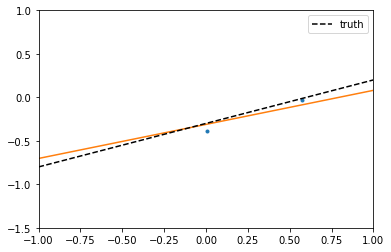

In [151]:
plt.plot(X,t, ".")
plt.xlim(-1, 1)
plt.ylim(-1.5, 1)
plt.plot(X_test, phi_test.dot(post_mean))
plt.plot(X_test, y_true, '--', c="black", label="truth")
plt.legend()

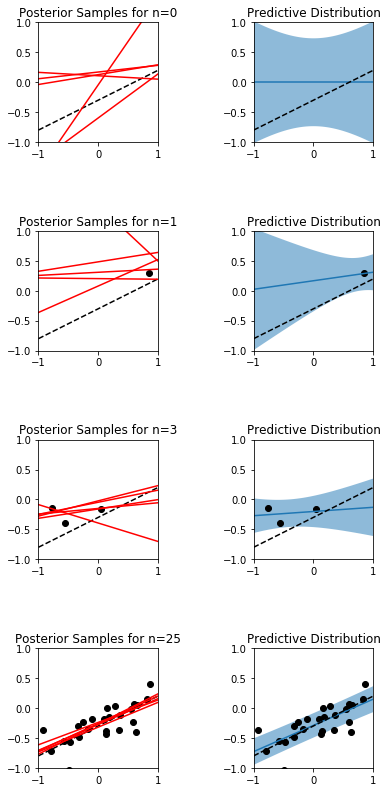

In [378]:
plt.figure(figsize=(6, 15))
plt.subplots_adjust(hspace=0.1, wspace=0.8)

for i, n in enumerate(N): 
    X = (np.random.rand(n,1) * 2 - 1)
    t = f(X, noise_variance=variance)
    phi = attach_ones(X)
    m_N, S_N = posterior(alpha, beta, phi, t)
    post_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5)
    y, y_var = predictive(phi_test, m_N, S_N, beta)
    
    plt.subplot(len(N), 2, i * 2 + 1)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(f"Posterior Samples for n={n}")

    plot_truth(X_test,y_true)
    plot_observed(X,t)
    
    y_sample = post_samples.dot(phi_test.T).T
    for c in range(post_samples.shape[0]):
        plt.plot(X_test[:,0], y_sample[:,c], c="red")
    
    plt.subplot(len(N), 2, i * 2 + 2)
    plt.xlim((-1,1))
    plt.ylim((-1,1))
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Predictive Distribution")
    plot_predictive(X_test, y, np.sqrt(y_var))
    plot_observed(X,t)
    plot_truth(X_test,y_true)

plt.draw()